<a href="https://colab.research.google.com/github/Achyuta-Harshavardhan/Cotton_Disease_Detection/blob/main/Cotton_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.7977629329999445
GPU (s):
0.1058684939999921
GPU speedup over CPU: 26x


In [2]:
# Import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [3]:
# Download InceptionV3 model
inception = InceptionV3(input_shape=(224,224,3),weights='imagenet',include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [4]:
# Make all the layers as non trainable
inception.trainable = False

In [5]:
# Glob used to find the number of class labels
folders = glob('/content/drive/MyDrive/Deep Learning/Cotton_Disease_Detection/Cotton Disease/test/*')

In [6]:
# Designing own layers as per problem statement
x = Flatten()(inception.output)

In [7]:
# final prediction layer
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
# Model Creation
model = Model(inputs=inception.input, outputs=prediction)

In [9]:
# Summary of Model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# Train and Test Datagenerators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Training Set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Deep Learning/Cotton_Disease_Detection/Cotton Disease/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1958 images belonging to 4 classes.


In [13]:
# Test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Deep Learning/Cotton_Disease_Detection/Cotton Disease/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 253 images belonging to 4 classes.


In [14]:
r = model.fit( training_set,
               validation_data=test_set,
               epochs=5,
               steps_per_epoch=len(training_set),
               validation_steps=len(test_set))

Epoch 1/5
62/62 [==============================] - 1270s 20s/step - loss: 3.1240 - accuracy: 0.6971 - val_loss: 0.7373 - val_accuracy: 0.8577
Epoch 2/5
62/62 [==============================] - 34s 545ms/step - loss: 0.5878 - accuracy: 0.8943 - val_loss: 0.4652 - val_accuracy: 0.8933
Epoch 3/5
62/62 [==============================] - 33s 537ms/step - loss: 0.5117 - accuracy: 0.9040 - val_loss: 0.6292 - val_accuracy: 0.9012
Epoch 4/5
62/62 [==============================] - 34s 541ms/step - loss: 0.4656 - accuracy: 0.9168 - val_loss: 0.3569 - val_accuracy: 0.9447
Epoch 5/5
62/62 [==============================] - 33s 537ms/step - loss: 0.3618 - accuracy: 0.9362 - val_loss: 0.4263 - val_accuracy: 0.9130


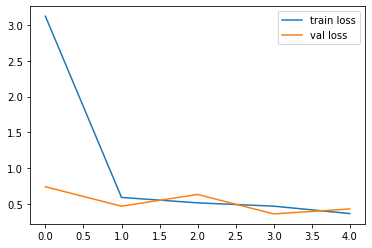

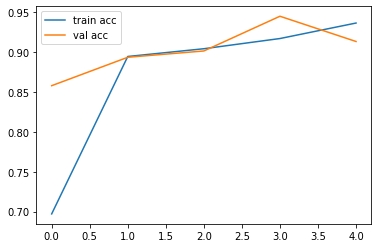

<Figure size 432x288 with 0 Axes>

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
# save the model
model.save('/content/drive/MyDrive/Deep Learning/Cotton_Disease_Detection/model_inception.h5')

In [17]:
# Load the model
model1 = load_model('/content/drive/MyDrive/Deep Learning/Cotton_Disease_Detection/model_inception.h5')

In [18]:
# Prediction
pred = model1.predict(test_set)

In [19]:
pred

array([[6.0047729e-19, 1.0000000e+00, 1.4948701e-21, 9.1098906e-10],
       [1.0317412e-19, 3.2441846e-01, 2.0250694e-16, 6.7558151e-01],
       [9.9992669e-01, 1.8376155e-10, 7.3357260e-05, 2.8951255e-13],
       ...,
       [7.9510795e-07, 4.4471017e-06, 4.5664334e-15, 9.9999475e-01],
       [4.4589950e-21, 1.0302573e-14, 1.3554036e-24, 1.0000000e+00],
       [2.7945921e-13, 1.1021901e-12, 1.3317518e-15, 1.0000000e+00]],
      dtype=float32)

In [20]:
pred = np.argmax(pred,axis=1)

In [21]:
pred

array([1, 3, 0, 3, 2, 0, 1, 2, 1, 3, 2, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1,
       0, 3, 3, 2, 1, 1, 1, 3, 2, 0, 3, 3, 0, 3, 1, 3, 1, 1, 3, 2, 0, 3,
       2, 2, 3, 2, 2, 1, 0, 3, 2, 1, 1, 3, 3, 1, 0, 1, 2, 0, 2, 1, 1, 2,
       1, 1, 1, 0, 1, 1, 2, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1,
       2, 1, 2, 2, 2, 2, 1, 3, 0, 1, 1, 2, 2, 1, 3, 1, 1, 3, 3, 3, 3, 2,
       0, 3, 3, 1, 1, 2, 2, 3, 0, 0, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2,
       3, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 3, 0, 1, 2, 0, 2, 2, 0, 1, 0,
       3, 2, 0, 2, 2, 3, 0, 2, 1, 2, 0, 3, 3, 1, 0, 0, 1, 1, 2, 0, 1, 1,
       0, 3, 3, 2, 2, 1, 1, 2, 3, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 1, 2, 1,
       2, 0, 1, 2, 1, 3, 2, 2, 1, 3, 3, 2, 2, 1, 3, 1, 1, 0, 1, 1, 3, 0,
       2, 2, 1, 3, 3, 2, 3, 0, 1, 0, 3, 0, 3, 3, 3, 2, 0, 0, 1, 3, 0, 1,
       1, 2, 2, 3, 3, 1, 0, 3, 3, 3, 3])